# Bhutan ClimateSense Project Weather Model Comparison

## What's in this Notebook

* Download, process and save:
** GraphCastFS data - Directly from AWS bucket (NOAA)
** CFSv2 Data - Directly from AWS bucket (NOAA)
** ERA5 Data - From Spreadsheet
* Calculate MSE and MAE
* Plot values

### GraphCastCFS




## GraphcastCFS download test
Only loads and graphs graphcast data

In [3]:
# Colab setup: ecCodes (for GRIB) + Python libs
!apt-get -y update >/dev/null 2>&1
!apt-get -y install libeccodes0 >/dev/null 2>&1

!pip -q install xarray cfgrib fsspec pandas numpy matplotlib


In [4]:
# === REQUIRED: paste your exact "index.html#" base URL here ===
# Keep the trailing slash; this must end with .../forecasts_13_levels/
BASE_INDEX_URL = "https://noaa-nws-graphcastgfs-pds.s3.amazonaws.com/index.html#graphcastgfs.20240205/12/forecasts_13_levels/"

# Also set these so filenames are nice (used only for saving)
DATE_YMD = "20240205"   # e.g., 20240205
HOUR     = "12"         # 00 / 06 / 12 / 18

# Region: Bhutan (lat N->S, lon W->E)
BHUTAN_BBOX = {'N': 28.3, 'S': 26.7, 'W': 88.7, 'E': 92.1}

# 10 days in 6h steps -> f006 ... f240
FORECAST_LENGTH_HOURS = 240
LEAD_STEP_HOURS = 6

# Variables to keep if present (13-level files usually have 't','u','v','z','q' on isobaric levels)
# We'll try to open pressure levels by default; you can change MESSAGE_FILTER below if needed.
VARS_WISHLIST = ["t", "u", "v", "z", "q", "t2m", "u10", "v10", "tp"]

# cfgrib filter: read only pressure-level messages (most common for "forecasts_13_levels")
# Alternatives you can try if needed:
#   {"typeOfLevel": "surface"}
#   {"typeOfLevel": "heightAboveGround"}
MESSAGE_FILTER = {"typeOfLevel": "isobaricInhPa"}

OUTPUT_DIR = "/content/bhutan_outputs"


In [5]:
import os, shutil, io, sys
import xarray as xr
import fsspec
import pandas as pd
import numpy as np

os.makedirs(OUTPUT_DIR, exist_ok=True)

def index_to_object_url(index_url: str) -> str:
    """
    Convert an S3 static-website listing URL like:
      https://.../index.html#graphcastgfs.20240205/12/forecasts_13_levels/graphcastgfs.t12z.pgrb2.0p25.f006
    into the real object URL (what we can download):
      https://.../graphcastgfs.20240205/12/forecasts_13_levels/graphcastgfs.t12z.pgrb2.0p25.f006
    """
    return index_url.replace("index.html#", "")

def build_index_urls(prefix_index_url: str, hour: str, lead_step=6, length_hours=240):
    lead_tags = [f"{h:03d}" for h in range(lead_step, length_hours+lead_step, lead_step)]
    # prefix_index_url should end with .../forecasts_13_levels/
    return [
        f"{prefix_index_url}graphcastgfs.t{hour}z.pgrb2.0p25.f{tag}"
        for tag in lead_tags
    ]

def download_via_http(object_url: str, out_dir: str) -> str:
    """
    Download a (converted) object URL to a local file and return the local path.
    Uses fsspec's HTTPFileSystem (no AWS creds needed).
    """
    local_path = os.path.join(out_dir, os.path.basename(object_url))
    with fsspec.open(object_url, "rb") as fsrc, open(local_path, "wb") as fdst:
        shutil.copyfileobj(fsrc, fdst)
    return local_path

def open_grib_from_index_url(index_url: str, filter_by_keys=None) -> xr.Dataset:
    """
    Accepts the index.html# style URL, converts it, downloads the GRIB, and opens it with cfgrib.
    """
    obj_url = index_to_object_url(index_url)
    local_fn = download_via_http(obj_url, OUTPUT_DIR)
    backend_kwargs = {"indexpath": ""}
    if filter_by_keys:
        backend_kwargs["filter_by_keys"] = filter_by_keys
    ds = xr.open_dataset(local_fn, engine="cfgrib", backend_kwargs=backend_kwargs)
    return ds

def normalize_time_and_lon(ds: xr.Dataset) -> xr.Dataset:
    # Valid time
    if "valid_time" in ds.coords:
        ds = ds.assign_coords(time=ds["valid_time"]).drop_vars(["valid_time"])
    elif "time" in ds.coords and "step" in ds.coords:
        ds = ds.assign_coords(time=ds["time"] + ds["step"])
    # Longitude from 0–360 to -180–180 if needed
    if "longitude" in ds.coords:
        lon = ds["longitude"]
        try:
            if float(lon.max()) > 180:
                ds = ds.assign_coords(longitude=((lon + 180) % 360) - 180).sortby("longitude")
        except Exception:
            pass
    return ds

def clip_to_bhutan(ds: xr.Dataset) -> xr.Dataset:
    return ds.sel(latitude=slice(BHUTAN_BBOX["N"], BHUTAN_BBOX["S"]),
                  longitude=slice(BHUTAN_BBOX["W"], BHUTAN_BBOX["E"]))


In [6]:
# Build the list of index.html# file URLs for all leads
file_index_urls = build_index_urls(BASE_INDEX_URL, HOUR, LEAD_STEP_HOURS, FORECAST_LENGTH_HOURS)
print("Example file URL (index.html# form):", file_index_urls[0])

datasets = []
errors = []

# We'll try a small sequence of filters in case the file carries multiple GRIB message groups.
FILTERS_TO_TRY = [MESSAGE_FILTER, {"typeOfLevel": "surface"}, {"typeOfLevel": "heightAboveGround"}, None]

for idx, idx_url in enumerate(file_index_urls, start=1):
    last_err = None
    ds_ok = None
    for flt in FILTERS_TO_TRY:
        try:
            ds_tmp = open_grib_from_index_url(idx_url, filter_by_keys=flt)
            ds_tmp = normalize_time_and_lon(ds_tmp)
            ds_tmp = clip_to_bhutan(ds_tmp)
            # Keep only desired variables if provided
            if VARS_WISHLIST:
                keep = [v for v in VARS_WISHLIST if v in ds_tmp.variables]
                if keep:
                    ds_tmp = ds_tmp[keep]
            # Clean encodings
            for v in ds_tmp.data_vars:
                ds_tmp[v].encoding = {}
            ds_ok = ds_tmp
            break
        except Exception as e:
            last_err = e
            continue
    if ds_ok is None:
        errors.append((idx_url, repr(last_err)))
        print(f"[{idx}/{len(file_index_urls)}] FAILED -> {idx_url} :: {last_err}")
    else:
        datasets.append(ds_ok)
        if idx % 10 == 0:
            print(f"[{idx}/{len(file_index_urls)}] OK")

if not datasets:
    raise RuntimeError("No GraphCast files opened. Check BASE_INDEX_URL, HOUR, and that the cycle exists.")

gc_ds = xr.concat(datasets, dim="time").sortby("time")
gc_ds


Example file URL (index.html# form): https://noaa-nws-graphcastgfs-pds.s3.amazonaws.com/index.html#graphcastgfs.20240205/12/forecasts_13_levels/graphcastgfs.t12z.pgrb2.0p25.f006


/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attr

[10/40] OK


/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attr

[20/40] OK


/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attr

[30/40] OK


/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attr

[40/40] OK


<xarray.Dataset> Size: 816kB
Dimensions:        (time: 40, isobaricInhPa: 13, latitude: 7, longitude: 14)
Coordinates:
  * time           (time) datetime64[ns] 320B 2024-02-05T18:00:00 ... 2024-02...
    step           (time) timedelta64[ns] 320B 0 days 06:00:00 ... 10 days 00...
  * isobaricInhPa  (isobaricInhPa) float64 104B 1e+03 925.0 850.0 ... 100.0 50.0
  * latitude       (latitude) float64 56B 28.25 28.0 27.75 27.5 27.25 27.0 26.75
  * longitude      (longitude) float64 112B 88.75 89.0 89.25 ... 91.5 91.75 92.0
Data variables:
    t              (time, isobaricInhPa, latitude, longitude) float32 204kB 2...
    u              (time, isobaricInhPa, latitude, longitude) float32 204kB 0...
    v              (time, isobaricInhPa, latitude, longitude) float32 204kB 1...
    q              (time, isobaricInhPa, latitude, longitude) float32 204kB 0...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             egrr
    GRIB_centreDescription:  U.K. Met Office - Exeter
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             U.K. Met Office - Exeter
    history:                 2025-08-09T12:02 GRIB to CDM+CF via cfgrib-0.9.1...

In [7]:
# Save NetCDF
nc_path = f"{OUTPUT_DIR}/graphcastgfs_{DATE_YMD}_{HOUR}z_bhutan_10d.nc"
gc_ds.to_netcdf(nc_path)

# Region mean (lat/lon)
spatial_dims = [d for d in ["latitude","longitude"] if d in gc_ds.dims]
gc_mean = gc_ds.mean(dim=spatial_dims, keep_attrs=True).copy()

# If 2-m temperature is present, provide a °C convenience variable
if "t2m" in gc_mean:
    gc_mean["t2m_c"] = gc_mean["t2m"] - 273.15

csv_path = f"{OUTPUT_DIR}/graphcastgfs_{DATE_YMD}_{HOUR}z_bhutan_10d_mean.csv"
gc_mean.to_dataframe().to_csv(csv_path)

print("Saved:")
print("  NetCDF:", nc_path)
print("  CSV   :", csv_path)


Saved:
  NetCDF: /content/bhutan_outputs/graphcastgfs_20240205_12z_bhutan_10d.nc
  CSV   : /content/bhutan_outputs/graphcastgfs_20240205_12z_bhutan_10d_mean.csv


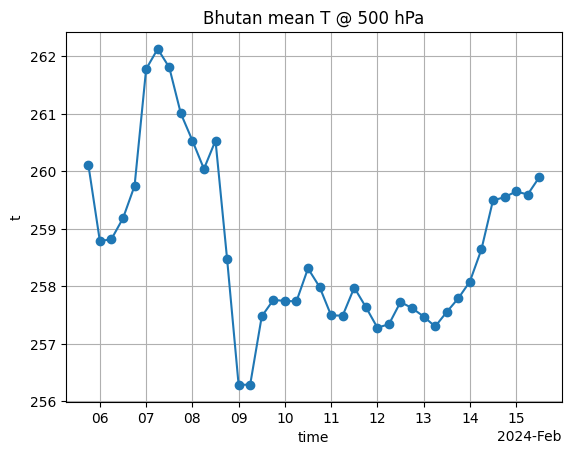

In [8]:
import matplotlib.pyplot as plt

# If pressure-level temperature exists, try 500 hPa as a demo
if "t" in gc_ds.data_vars and "isobaricInhPa" in gc_ds.dims:
    try:
        t500 = gc_ds["t"].sel(isobaricInhPa=500).mean(dim=["latitude","longitude"])
        t500.plot(marker="o")
        plt.title("Bhutan mean T @ 500 hPa")
        plt.grid(True)
        plt.show()
    except Exception as e:
        print("Plot skipped:", e)

# If 't2m_c' exists (near-surface), plot that too
if "t2m" in gc_ds.data_vars:
    t2m_c = (gc_ds["t2m"] - 273.15).mean(dim=["latitude","longitude"])
    t2m_c.plot(marker="o")
    plt.title("Bhutan mean 2m Temperature (°C)")
    plt.grid(True)
    plt.show()


# Version 2
Loads data from graphcastcfs, CFSv2 and ERA5

### GraphCastCFS ✅

In [106]:
# System GRIB libs for cfgrib/eccodes
!apt-get -y update >/dev/null 2>&1
!apt-get -y install libeccodes0 >/dev/null 2>&1

# Python deps
!pip -q install xarray cfgrib fsspec pandas numpy matplotlib scikit-learn cdsapi


In [107]:
# === REQUIRED: paste your exact GraphCastCFS base URL (keep index.html# and trailing slash) ===
BASE_INDEX_URL = "https://noaa-nws-graphcastgfs-pds.s3.amazonaws.com/index.html#graphcastgfs.20240205/12/forecasts_13_levels/"

# For filenames / labeling
DATE_YMD = "20240205"   # match your BASE_INDEX_URL (YYYYMMDD)
HOUR     = "12"         # 00 / 06 / 12 / 18

# Region: Bhutan
BHUTAN_BBOX = {'N': 28.3, 'S': 26.7, 'W': 88.7, 'E': 92.1}

# Leads: 10 days in 6h steps
FORECAST_LENGTH_HOURS = 240
LEAD_STEP_HOURS = 6

# Vars to try keeping (if present)
VARS_WISHLIST = ["t2m", "u10", "v10", "tp", "t", "u", "v", "z", "q"]

# cfgrib message filter (try pressure levels first; code will fall back automatically)
MESSAGE_FILTER = {"typeOfLevel": "isobaricInhPa"}

# Output dir
OUTPUT_DIR = "/content/bhutan_outputs"

In [104]:
import os, shutil
import fsspec, xarray as xr, pandas as pd, numpy as np
os.makedirs(OUTPUT_DIR, exist_ok=True)

def index_to_object_url(index_url: str) -> str:
    # Convert "index.html#..." to the real HTTP object URL
    return index_url.replace("index.html#", "")

def build_lead_tags(step=6, length_hours=240):
    return [f"{h:03d}" for h in range(step, length_hours+step, step)]

def build_gc_index_urls(prefix_index_url: str, hour: str, lead_tags):
    # prefix_index_url must end with .../forecasts_13_levels/
    return [f"{prefix_index_url}graphcastgfs.t{hour}z.pgrb2.0p25.f{tag}" for tag in lead_tags]

def http_download(object_url: str, out_dir: str) -> str:
    local_path = os.path.join(out_dir, os.path.basename(object_url))
    with fsspec.open(object_url, "rb") as fsrc, open(local_path, "wb") as fdst:
        shutil.copyfileobj(fsrc, fdst)
    return local_path

def open_grib_from_index_url(index_url: str, filter_by_keys=None) -> xr.Dataset:
    obj_url = index_to_object_url(index_url)
    local_fn = http_download(obj_url, OUTPUT_DIR)
    bk = {"indexpath": ""}
    if filter_by_keys:
        bk["filter_by_keys"] = filter_by_keys
    return xr.open_dataset(local_fn, engine="cfgrib", backend_kwargs=bk)

def normalize_time_and_lon(ds: xr.Dataset) -> xr.Dataset:
    # time/step → time(valid_time)
    if "valid_time" in ds.coords:
        ds = ds.assign_coords(time=ds["valid_time"]).drop_vars(["valid_time"])
    elif "time" in ds.coords and "step" in ds.coords:
        ds = ds.assign_coords(time=ds["time"] + ds["step"])
    # lon 0–360 → -180–180
    if "longitude" in ds.coords:
        lon = ds["longitude"]
        try:
            if float(lon.max()) > 180:
                ds = ds.assign_coords(longitude=((lon + 180) % 360) - 180).sortby("longitude")
        except Exception:
            pass
    return ds

def clip_to_bhutan(ds: xr.Dataset) -> xr.Dataset:
    return ds.sel(latitude=slice(BHUTAN_BBOX["N"], BHUTAN_BBOX["S"]),
                  longitude=slice(BHUTAN_BBOX["W"], BHUTAN_BBOX["E"]))

In [108]:
lead_tags = build_lead_tags(LEAD_STEP_HOURS, FORECAST_LENGTH_HOURS)
gc_index_urls = build_gc_index_urls(BASE_INDEX_URL, HOUR, lead_tags)
print("Example GC file (index.html# form):", gc_index_urls[0])

FILTERS_TO_TRY = [MESSAGE_FILTER, {"typeOfLevel": "surface"}, {"typeOfLevel": "heightAboveGround"}, None]

gc_parts, gc_errors = [], []
for i, idx_url in enumerate(gc_index_urls, 1):
    ds_ok, last_err = None, None
    for flt in FILTERS_TO_TRY:
        try:
            ds = open_grib_from_index_url(idx_url, filter_by_keys=flt)
            ds = normalize_time_and_lon(ds)
            ds = clip_to_bhutan(ds)
            if VARS_WISHLIST:
                keep = [v for v in VARS_WISHLIST if v in ds.variables]
                if keep: ds = ds[keep]
            for v in ds.data_vars: ds[v].encoding = {}
            ds_ok = ds
            break
        except Exception as e:
            last_err = e
            continue
    if ds_ok is None:
        gc_errors.append((idx_url, repr(last_err)))
        print(f"[GC {i}/{len(gc_index_urls)}] FAILED   {idx_url} :: {last_err}")
    else:
        gc_parts.append(ds_ok)
        if i % 10 == 0: print(f"[GC {i}/{len(gc_index_urls)}] OK")

if not gc_parts:
    raise RuntimeError("No GraphCast files opened. Check BASE_INDEX_URL/HOUR/DATE.")

gc_ds = xr.concat(gc_parts, dim="time").sortby("time")
gc_ds

Example GC file (index.html# form): https://noaa-nws-graphcastgfs-pds.s3.amazonaws.com/index.html#graphcastgfs.20240205/12/forecasts_13_levels/graphcastgfs.t12z.pgrb2.0p25.f006


/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attr

[GC 10/40] OK


/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attr

[GC 20/40] OK


/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attr

[GC 30/40] OK


/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attr

[GC 40/40] OK


<xarray.Dataset> Size: 816kB
Dimensions:        (time: 40, isobaricInhPa: 13, latitude: 7, longitude: 14)
Coordinates:
  * time           (time) datetime64[ns] 320B 2024-02-05T18:00:00 ... 2024-02...
    step           (time) timedelta64[ns] 320B 0 days 06:00:00 ... 10 days 00...
  * isobaricInhPa  (isobaricInhPa) float64 104B 1e+03 925.0 850.0 ... 100.0 50.0
  * latitude       (latitude) float64 56B 28.25 28.0 27.75 27.5 27.25 27.0 26.75
  * longitude      (longitude) float64 112B 88.75 89.0 89.25 ... 91.5 91.75 92.0
Data variables:
    t              (time, isobaricInhPa, latitude, longitude) float32 204kB 2...
    u              (time, isobaricInhPa, latitude, longitude) float32 204kB 0...
    v              (time, isobaricInhPa, latitude, longitude) float32 204kB 1...
    q              (time, isobaricInhPa, latitude, longitude) float32 204kB 0...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             egrr
    GRIB_centreDescription:  U.K. Met Office - Exeter
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             U.K. Met Office - Exeter
    history:                 2025-08-11T13:52 GRIB to CDM+CF via cfgrib-0.9.1...

In [11]:
gc_nc = f"{OUTPUT_DIR}/graphcastcfs_{DATE_YMD}_{HOUR}z_bhutan_10d.nc"
gc_ds.to_netcdf(gc_nc)

spatial_dims = [d for d in ["latitude","longitude"] if d in gc_ds.dims]
gc_mean = gc_ds.mean(dim=spatial_dims, keep_attrs=True).copy()
if "t2m" in gc_mean: gc_mean["t2m_c"] = gc_mean["t2m"] - 273.15
gc_csv = f"{OUTPUT_DIR}/graphcastcfs_{DATE_YMD}_{HOUR}z_bhutan_10d_mean.csv"
gc_mean.to_dataframe().to_csv(gc_csv)

print("Saved GC →", gc_nc, "and", gc_csv)
"""
# Time window we will match for CFSv2 and ERA5:
t_start = pd.to_datetime(gc_ds.time.values).min()
t_end   = pd.to_datetime(gc_ds.time.values).max()
t_start, t_end
"""


Saved GC → /content/bhutan_outputs/graphcastcfs_20240205_12z_bhutan_10d.nc and /content/bhutan_outputs/graphcastcfs_20240205_12z_bhutan_10d_mean.csv


(Timestamp('2024-02-05 18:00:00'), Timestamp('2024-02-15 12:00:00'))

In [59]:
import pandas as pd

# Load the GraphCastCFS mean data from the CSV file
gc_df = pd.read_csv("/content/bhutan_outputs/graphcastcfs_20240205_12z_bhutan_10d_mean.csv", index_col="time", parse_dates=True)

# Convert temperature from Kelvin in column "t" to Celsius in a new column "t2m_c"
if 't' in gc_df.columns:
    gc_df['t2m_c'] = gc_df['t'] - 273.15
elif 't2m' in gc_df.columns:
    # Keep existing conversion if 't' is not available but 't2m' is
    gc_df['t2m_c'] = gc_df['t2m'] - 273.15
else:
    print("Warning: Neither 't' nor 't2m' temperature column found in gc_df.")


# Display the first few rows of the dataframe
display(gc_df.head())

,isobaricInhPa,t,u,v,q,step,t2m_c
time,,,,,,,
2024-02-05 18:00:00,1000.0,289.60740,0.005795,0.465771,0.005606,0 days 06:00:00,16.45740
2024-02-05 18:00:00,925.0,285.35974,0.026587,0.755970,0.004795,0 days 06:00:00,12.20974
2024-02-05 18:00:00,850.0,280.61484,0.865909,0.872481,0.004377,0 days 06:00:00,7.46484
2024-02-05 18:00:00,700.0,271.11386,5.159141,1.011449,0.003149,0 days 06:00:00,-2.03614
2024-02-05 18:00:00,600.0,264.58536,12.226614,0.683886,0.001589,0 days 06:00:00,-8.56464


## Acces CFSv2 data ✅


In [12]:
# === REQUIRED: match the GraphCastCFS cycle used ===
CFS_DATE_YMD = DATE_YMD     # e.g., "20240205"
CFS_HOUR     = HOUR         # "00" / "06" / "12" / "18"

# Base *index* URL for the CDAS folder (KEEP index.html# and trailing slash)
CFS_BASE_INDEX_DIR = f"https://noaa-cfs-pds.s3.amazonaws.com/index.html#cdas.{CFS_DATE_YMD}/"

# Leads: same as GraphCastCFS (10 days @ 6h)
CFS_LEAD_STEP_HOURS    = 6
CFS_FORECAST_LENGTH_HR = 240
CFS_LEAD_TAGS = [f"{h:03d}" for h in range(CFS_LEAD_STEP_HOURS, CFS_FORECAST_LENGTH_HR + CFS_LEAD_STEP_HOURS, CFS_LEAD_STEP_HOURS)]

# Reuse Bhutan bbox and output dir from earlier cells:
# BHUTAN_BBOX, OUTPUT_DIR, VARS_WISHLIST should already be defined
# If not, (re)define quickly here:
BHUTAN_BBOX = BHUTAN_BBOX if 'BHUTAN_BBOX' in globals() else {'N': 28.3, 'S': 26.7, 'W': 88.7, 'E': 92.1}
OUTPUT_DIR = OUTPUT_DIR if 'OUTPUT_DIR' in globals() else "/content/bhutan_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [13]:
import os, shutil
import fsspec
import xarray as xr
import pandas as pd
import numpy as np

def index_to_object_url(index_url: str) -> str:
    # Convert "index.html#..." to the real object URL we can download
    return index_url.replace("index.html#", "")

def http_download(object_url: str, out_dir: str) -> str:
    local_path = os.path.join(out_dir, os.path.basename(object_url))
    with fsspec.open(object_url, "rb") as fsrc, open(local_path, "wb") as fdst:
        shutil.copyfileobj(fsrc, fdst)
    return local_path

def open_grib_from_index_url(index_url: str, filter_by_keys=None) -> xr.Dataset:
    obj_url = index_to_object_url(index_url)
    local_fn = http_download(obj_url, OUTPUT_DIR)
    bk = {"indexpath": ""}
    if filter_by_keys:
        bk["filter_by_keys"] = filter_by_keys
    return xr.open_dataset(local_fn, engine="cfgrib", backend_kwargs=bk)

def normalize_time_and_lon(ds: xr.Dataset) -> xr.Dataset:
    # Promote valid time
    if "valid_time" in ds.coords:
        ds = ds.assign_coords(time=ds["valid_time"]).drop_vars(["valid_time"])
    elif "time" in ds.coords and "step" in ds.coords:
        ds = ds.assign_coords(time=ds["time"] + ds["step"])
    # Normalize longitude to -180..180
    if "longitude" in ds.coords:
        lon = ds["longitude"]
        try:
            if float(lon.max()) > 180:
                ds = ds.assign_coords(longitude=((lon + 180) % 360) - 180).sortby("longitude")
        except Exception:
            pass
    return ds

def clip_to_bhutan(ds: xr.Dataset) -> xr.Dataset:
    return ds.sel(latitude=slice(BHUTAN_BBOX["N"], BHUTAN_BBOX["S"]),
                  longitude=slice(BHUTAN_BBOX["W"], BHUTAN_BBOX["E"]))


The file naming has the format cdas1. t{hour}z.ipvgrbf{number}.gribs
* hour is the the hours 00, 06, 12, 18
* number is an integer from 0 to 9 with a leading zero e.g. 00, 01, 02, etc
* for example cdas1.t00z.ipvgrbf00.grib2 wit

In [14]:
# === CFS/CDAS helpers (ipvgrbfNN) ===
# Assumes you already set:
#   CFS_DATE_YMD = DATE_YMD   # e.g. "20240205"
#   CFS_HOUR     = HOUR       # "00" | "06" | "12" | "18"
#   CFS_BASE_INDEX_DIR = f"https://noaa-cfs-pds.s3.amazonaws.com/index.html#cdas.{CFS_DATE_YMD}/"
# and you already have:
#   open_grib_from_index_url(), normalize_time_and_lon(), clip_to_bhutan(), VARS_WISHLIST

def cfs_cdas_index_url_ipvgrb(hour: str, n: int) -> str:
    """Return the exact index.html# URL for cdas1.t{hour}z.ipvgrbf{nn}.grib2 (nn=00..09)."""
    nn = f"{n:02d}"
    fname = f"cdas1.t{hour}z.ipvgrbf{nn}.grib2"
    return CFS_BASE_INDEX_DIR + fname  # keep index.html# prefix

def open_cdas_ipvgrb_for_n(n: int):
    """
    Open a single CDAS ipvgrbfNN file for the configured date/hour.
    Tries a few filter_by_keys; returns (Dataset, used_index_url).
    """
    idx_url = cfs_cdas_index_url_ipvgrb(CFS_HOUR, n)

    FILTERS_TO_TRY = [
        {"typeOfLevel": "surface"},
        {"typeOfLevel": "heightAboveGround"},
        {"typeOfLevel": "isobaricInhPa"},
        None,  # fallback
    ]
    last_err = None
    for flt in FILTERS_TO_TRY:
        try:
            ds = open_grib_from_index_url(idx_url, filter_by_keys=flt)
            ds = normalize_time_and_lon(ds)
            ds = clip_to_bhutan(ds)
            if 'VARS_WISHLIST' in globals() and VARS_WISHLIST:
                keep = [v for v in VARS_WISHLIST if v in ds.variables]
                if keep:
                    ds = ds[keep]
            for v in ds.data_vars:
                ds[v].encoding = {}
            return ds, idx_url
        except Exception as e:
            last_err = e
            continue
    raise FileNotFoundError(f"Could not open {idx_url}. Last error: {last_err}")


In [46]:
# Build the 10-file stack for nn=00..09 (ipvgrbf00 .. ipvgrbf09)
import os
import xarray as xr

cfs_parts, cfs_errors = [], []

for n in range(0, 10):  # nn=00..09
    try:
        ds, used = open_cdas_ipvgrb_for_n(n)
        cfs_parts.append(ds)
        if (n+1) % 5 == 0:
            print(f"[CDAS {n:02d}/09] OK → {os.path.basename(used)}")
    except Exception as e:
        cfs_errors.append((n, repr(e)))
        print(f"[CDAS {n:02d}/09] FAILED → {e}")

if not cfs_parts:
    raise RuntimeError("No CDAS/CFS ipvgrbfNN files opened. Check date/hour and folder contents.")

cfs_ds = xr.concat(cfs_parts, dim="time").sortby("time")
cfs_ds


/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attr

[CDAS 04/09] OK → cdas1.t12z.ipvgrbf04.grib2


/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attr

[CDAS 09/09] OK → cdas1.t12z.ipvgrbf09.grib2


<xarray.Dataset> Size: 536B
Dimensions:    (time: 10, latitude: 2, longitude: 4)
Coordinates:
  * time       (time) datetime64[ns] 80B 2024-02-05T12:00:00 ... 2024-02-05T2...
    step       (time) timedelta64[ns] 80B 00:00:00 01:00:00 ... 09:00:00
    surface    float64 8B 0.0
  * latitude   (latitude) float64 16B 28.0 27.0
  * longitude  (longitude) float64 32B 89.0 90.0 91.0 92.0
Data variables:
    t          (time, latitude, longitude) float32 320B 260.2 254.9 ... 278.6
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2025-08-11T12:43 GRIB to CDM+CF via cfgrib-0.9.1...

In [52]:
# convert the xarray dataset to a dataframe
cfs_df = cfs_ds.to_dataframe()

print(cfs_df.head())

                                                 t   step  surface
time                latitude longitude                            
2024-02-05 12:00:00 28.0     89.0       260.200012 0 days      0.0
                             90.0       254.899994 0 days      0.0
                             91.0       264.500000 0 days      0.0
                             92.0       256.799988 0 days      0.0
                    27.0     89.0       280.600006 0 days      0.0


In [53]:
# Convert temperature in CFS dataframe from Kelvin to Celsius
cfs_df['t2m_c'] = cfs_df['t'] - 273.15

# Check if latitude and longitude values are within the Bhutan bounding box
#lat_check = cfs_df.index.get_level_values('latitude').between(BHUTAN_BBOX['S'], BHUTAN_BBOX['N']).all()
#lon_check = cfs_df.index.get_level_values('longitude').between(BHUTAN_BBOX['W'], BHUTAN_BBOX['E']).all()

print(f"Temperature converted to Celsius. New column 't_c' added.")
#print(f"Latitude values within Bhutan bounding box: {lat_check}")
#print(f"Longitude values within Bhutan bounding box: {lon_check}")

display(cfs_df.head())

Temperature converted to Celsius. New column 't_c' added.


t   step  surface      t2m_c
time                latitude longitude                                       
2024-02-05 12:00:00 28.0     89.0       260.200012 0 days      0.0 -12.949982
                             90.0       254.899994 0 days      0.0 -18.250000
                             91.0       264.500000 0 days      0.0  -8.649994
                             92.0       256.799988 0 days      0.0 -16.350006
                    27.0     89.0       280.600006 0 days      0.0   7.450012

## Get ERA data from CSV ✅

In [19]:
from google.colab import drive
import pandas as pd

# 1️⃣ Mount Google Drive
drive.mount('/content/drive')

# 2️⃣ Path to your CSV in Drive
csv_path = "/content/drive/MyDrive/Bhutan ClimateSense/era5_from_excel_bhutan_mean_6h.csv"

# 3️⃣ Load into DataFrame
era5_df = pd.read_csv(csv_path, parse_dates=["time"], index_col="time")

# 4️⃣ Inspect
print(era5_df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                        t2m_c         t2m
time                                     
2024-01-01 00:00:00 -4.342628  268.807372
2024-01-01 06:00:00  4.881769  278.031769
2024-01-01 12:00:00  1.220796  274.370796
2024-01-01 18:00:00 -2.847994  270.302006
2024-01-02 00:00:00 -5.540658  267.609342


In [78]:
# Extract the hour:minute:second portion from the time index and create a new 'step' column
era5_df['step'] = era5_df.index.strftime('%H:%M:%S')

# Display the first few rows to show the new column
display(era5_df.head())

,t2m_c,t2m,step
time,,,
2024-01-01 00:00:00,-4.342628,268.807372,00:00:00
2024-01-01 06:00:00,4.881769,278.031769,06:00:00
2024-01-01 12:00:00,1.220796,274.370796,12:00:00
2024-01-01 18:00:00,-2.847994,270.302006,18:00:00
2024-01-02 00:00:00,-5.540658,267.609342,00:00:00


### Align data from the three sources

In [80]:
# Build the DataFrame used by your scoring cell
#e5_df = era5_ds.to_dataframe()

# If GraphCast/CFS means are already computed:
#   gc_mean_out -> DataFrame: gc_df
#   cfs_mean    -> DataFrame: cfs_df
try:
    gc_df  = gc_mean_out.to_dataframe()
except Exception:
    pass
try:
    cfs_df = cfs_mean.to_dataframe()
except Exception:
    pass
try:
    era5_df = era5_mean.to_dataframe()
except Exception:
    pass
# Align on common 6-hourly times
def safe_align(df_list):
    idx = None
    for d in df_list:
        if d is not None:
            idx = d.index if idx is None else idx.intersection(d.index)
    return [d.loc[idx] if d is not None else None for d in df_list], idx

(gc_al, cfs_al, era5_al), common_idx = safe_align([gc_df if 'gc_df' in globals() else None,
                                                 cfs_df if 'cfs_df' in globals() else None,
                                                 era5_df])

print("Aligned points:", len(common_idx))


Aligned points: 1


# Let's compare


### Align sources by time

In [81]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Ensure datetime index for gc_df (should already be datetime from loading)
# gc_df.index = pd.to_datetime(gc_df.index) # This is likely already done in the loading step

# Ensure datetime index for cfs_df
# Reset index to make 'time' a column, convert 'time' to datetime, then set 'time' as index
if isinstance(cfs_df.index, pd.MultiIndex):
    cfs_df = cfs_df.reset_index()
    cfs_df['time'] = pd.to_datetime(cfs_df['time'])
    cfs_df = cfs_df.set_index('time')
elif not pd.api.types.is_datetime64_any_dtype(cfs_df.index):
     cfs_df.index = pd.to_datetime(cfs_df.index)


# Ensure datetime index for era5_df (should already be datetime from loading)
# era5_df.index = pd.to_datetime(era5_df.index) # This is likely already done in the loading step

# Find common timestamps
common_idx = gc_df.index.intersection(cfs_df.index).intersection(era5_df.index)

# Restrict to common times
gc_al  = gc_df.loc[common_idx]
cfs_al = cfs_df.loc[common_idx]
era5_al = era5_df.loc[common_idx]

In [82]:
print("GraphCastCFS")
print(gc_al.head())
print("CFSv2")
print(cfs_al.head())
print("ERA5")
print(era5_al.head())

GraphCastCFS
                     isobaricInhPa          t          u         v         q  \
time                                                                           
2024-02-05 18:00:00         1000.0  289.60740   0.005795  0.465771  0.005606   
2024-02-05 18:00:00          925.0  285.35974   0.026587  0.755970  0.004795   
2024-02-05 18:00:00          850.0  280.61484   0.865909  0.872481  0.004377   
2024-02-05 18:00:00          700.0  271.11386   5.159141  1.011449  0.003149   
2024-02-05 18:00:00          600.0  264.58536  12.226614  0.683886  0.001589   

                                step     t2m_c  
time                                            
2024-02-05 18:00:00  0 days 06:00:00  16.45740  
2024-02-05 18:00:00  0 days 06:00:00  12.20974  
2024-02-05 18:00:00  0 days 06:00:00   7.46484  
2024-02-05 18:00:00  0 days 06:00:00  -2.03614  
2024-02-05 18:00:00  0 days 06:00:00  -8.56464  
CFSv2
                     latitude  longitude           t            step  surface

In [98]:
metrics = []
for var in ["t2m_c"]:  # replace with your actual variable names
    if var in gc_al.columns and var in cfs_al.columns and var in era5_al.columns:
        # Select the 1000 hPa level from gc_al and then the 't2m_c' column
        #gc_al_1000hPa_t2mc = gc_al[gc_al['isobaricInhPa'] == 1000.0][var]
        gc_al_t2mc = gc_al[var]

        # Select the 't2m_c' column for era5_al and cfs_al
        era5_al_t2mc = era5_al[var]
        cfs_al_t2mc = cfs_al[var]

        # Ensure the series to be compared have the same time index
        common_time_index_var = gc_al_t2mc.index.intersection(era5_al_t2mc.index).intersection(cfs_al_t2mc.index)


        # Align the series using the common time index
        gc_al_aligned_var = gc_al_t2mc.loc[common_time_index_var]
        era5_al_aligned_var = era5_al_t2mc.loc[common_time_index_var]
        cfs_al_aligned_var = cfs_al_t2mc.loc[common_time_index_var]

        # Calculate the spatial mean for cfs_al_aligned_var to match the other series
        cfs_al_aligned_var_mean = cfs_al_aligned_var.groupby('time').mean()

        # Check if there are enough samples for meaningful metric calculation
        if len(common_time_index_var) > 1 and not gc_al_aligned_var.empty and not era5_al_aligned_var.empty and not cfs_al_aligned_var_mean.empty:
            mse_gc  = mean_squared_error(era5_al_aligned_var, gc_al_aligned_var)
            mae_gc  = mean_absolute_error(era5_al_aligned_var, gc_al_aligned_var)
            mse_cfs = mean_squared_error(era5_al_aligned_var, cfs_al_aligned_var_mean) # Use the spatially-averaged CFS data
            mae_cfs = mean_absolute_error(era5_al_aligned_var, cfs_al_aligned_var_mean) # Use the spatially-averaged CFS data

            metrics.append({
                "variable": var,
                "MSE_GraphCastCFS": mse_gc,
                "MAE_GraphCastCFS": mae_gc,
                "MSE_CFSv2": mse_cfs,
                "MAE_CFSv2": mae_cfs
            })
        else:
             print(f"Warning: Not enough common time steps ({len(common_time_index_var)}) for meaningful metric calculation for variable '{var}'. Skipping metrics calculation.")


metrics_df = pd.DataFrame(metrics)
print(metrics_df)

Empty DataFrame
Columns: []
Index: []


### Explanation
This outputs an empty dataframe since there is only one common time index between the three dataframes

In [97]:
print(len(common_time_index_var))

1


In [99]:
display(metrics_df)

""


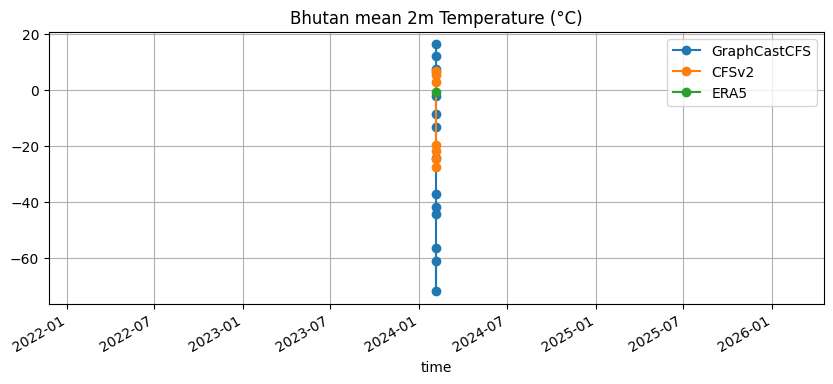

In [100]:
import matplotlib.pyplot as plt

if "t2m_c" in gc_al and "t2m_c" in cfs_al and "t2m_c" in era5_al:
    ax = gc_al["t2m_c"].plot(marker="o", figsize=(10,4), label="GraphCastCFS")
    cfs_al["t2m_c"].plot(marker="o", ax=ax, label="CFSv2")
    era5_al["t2m_c"].plot(marker="o", ax=ax, label="ERA5")
    plt.title("Bhutan mean 2m Temperature (°C)")
    plt.grid(True); plt.legend(); plt.show()


/tmp/ipython-input-3775994864.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gc_monthly_mean = gc_2024.resample('M').mean(numeric_only=True)['t2m_c']
/tmp/ipython-input-3775994864.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  cfs_monthly_mean = cfs_2024.resample('M').mean(numeric_only=True)['t2m_c']
/tmp/ipython-input-3775994864.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  era5_monthly_mean = era5_2024.resample('M').mean(numeric_only=True)['t2m_c']
/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high x

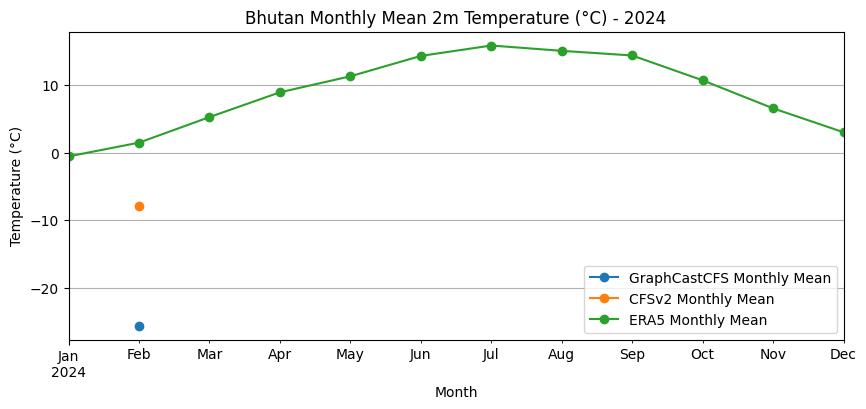

In [101]:
import matplotlib.pyplot as plt

# Filter data for the year 2024
gc_2024 = gc_df.loc['2024']
cfs_2024 = cfs_df.loc['2024']
era5_2024 = era5_df.loc['2024']

# Calculate monthly mean temperature ('t2m_c')
gc_monthly_mean = gc_2024.resample('M').mean(numeric_only=True)['t2m_c']
cfs_monthly_mean = cfs_2024.resample('M').mean(numeric_only=True)['t2m_c']
era5_monthly_mean = era5_2024.resample('M').mean(numeric_only=True)['t2m_c']

# Plotting the monthly means
plt.figure(figsize=(10, 4))
gc_monthly_mean.plot(marker="o", label="GraphCastCFS Monthly Mean")
cfs_monthly_mean.plot(marker="o", label="CFSv2 Monthly Mean")
era5_monthly_mean.plot(marker="o", label="ERA5 Monthly Mean")

plt.title("Bhutan Monthly Mean 2m Temperature (°C) - 2024")
plt.xlabel("Month")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.legend()
plt.show()

# Compare predictions for 2024
Plot the monthly mean temperature for the year 2024 using the unfiltered data from GraphCastCFS, CFSv2, and ERA5.